In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import igraph as ig
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import random
import h3
from tqdm import tqdm


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Urban centralities

### AMG

In [2]:
gdf = gpd.read_file('../data/external/Mancha_Urbana/ManchaUrbana_AMG_1902_2020.geojson', driver='GeoJSON')
gdf = gdf.to_crs("EPSG:32613")
gdf.rename(columns={'A�o':'year'}, inplace=True)
print(gdf.shape)
gdf.head(1)

(10, 4)


,year,layer,path,geometry
0,1980,1902-1940,/home/edgar/SIG/ObsCds/Proyectos/Guggenheim/Me...,"MULTIPOLYGON (((684400.887 2265337.193, 683917..."


<AxesSubplot:>

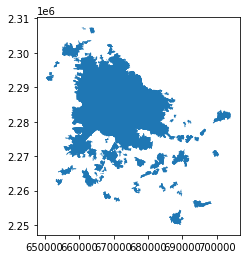

In [3]:
gdf.plot()

## Municipalities

### AMG

In [7]:
amg = {"Guadalajara":{"mpos":["14039", "14044", "14051", 
                              "14070", "14097", "14098", "14101", 
                              "14120", "14124"],"edo":["14"]}}
df_amg = pd.DataFrame(amg)
df_amg.head(1)

,Guadalajara
edo,[14]


In [8]:
mun_gdf = gpd.GeoDataFrame()

for m in df_amg.loc['mpos'][0]:
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
print(mun_gdf.shape)
mun_gdf.head(1)

(9, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7..."


<AxesSubplot:>

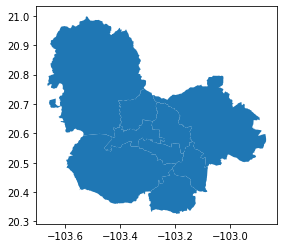

In [9]:
mun_gdf.plot()

In [10]:
mun_gdf = mun_gdf.reset_index().drop(columns='index')
mun_gdf = mun_gdf.to_crs("EPSG:4326")

## Hex-bins

In [11]:
res = 9
hex_gdf = aup.create_hexgrid(mun_gdf, res)

/home/edgar/Repos/Observatorio-ciudades/accesibilidad-urbana/aup/utils.py:335: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = polygon.explode().reset_index(drop=True)


In [12]:
print(hex_gdf.shape)
hex_gdf.head(2)

(27320, 2)


,geometry,hex_id_9
0,"POLYGON ((-103.35553 20.62840, -103.35343 20.6...",89498c9656bffff
1,"POLYGON ((-103.35689 20.61478, -103.35776 20.6...",89498c965c7ffff


<AxesSubplot:>

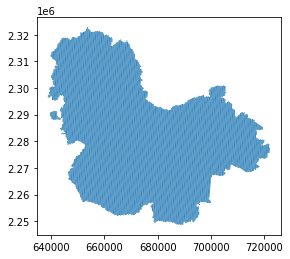

In [13]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_gdf.plot()

## Intersect

### Urban area for specific year t=0

In [14]:
list(gdf.year.unique())

[1980, 1940, 1970, 1902, 2000, 2005, 2010, 2015, 2020, 1990]

In [15]:
res_union = gpd.GeoDataFrame()

gdf = gdf.to_crs("EPSG:4326")

hex_12_mean_area = 363.5469406551828 #calculated previously
#hex_10_mean_area = 17813.347045541726 #calculated previously
hex_10_mean_area = hex_gdf.area.mean()

year_list = ['1990','2000','2010','2015']

for y in list(gdf.year.unique()):
    #filter urban area by year
    gdf_year = gdf.loc[(gdf.year==y)].copy()
    gdf_year = gdf_year.dissolve(by='year')
    gdf_year.reset_index(drop=True, inplace=True)
    
    #multiploygon to polygon
    polygons = gdf_year.geometry.explode(index_parts=True)
    
    all_polys = gpd.GeoDataFrame()
    
    #create hex grid for urban area
    for i in tqdm(range(len(polygons[0])), position=0, leave=True):
        dict_poly = polygons[0][i].__geo_interface__
        hexs = h3.polyfill(dict_poly, 12, geo_json_conformant = True)
        polygonise = lambda hex_id: Polygon(
                                    h3.h3_to_geo_boundary(
                                        hex_id, geo_json=True)
                                        )

        poly_tmp = gpd.GeoSeries(list(map(polygonise, hexs)), \
                                              index=hexs, \
                                              crs="EPSG:4326" \
                                             )
        gdf_tmp = gpd.GeoDataFrame(poly_tmp.reset_index()).rename(columns={'index':'hex_id_12',0:'geometry'})

        all_polys = all_polys.append(gdf_tmp, ignore_index=True)

    all_polys = all_polys.drop_duplicates()
    
    #group by parent hexagon
    all_polys['hex_id_9'] = np.nan
    all_polys['hex_id_9'] = all_polys.apply(lambda row: h3.h3_to_parent(row.hex_id_12, 9), axis=1)
    group_urb = all_polys.groupby('hex_id_9').count()
    group_urb['area'] = group_urb['hex_id_12']*hex_12_mean_area #calculate urban area
    group_urb.reset_index(inplace=True)
    group_urb.drop(columns=['hex_id_12','geometry'], inplace=True)
    
    #merge dataframes
    hex_urb = hex_gdf.merge(group_urb, on='hex_id_9', how='left')
    
    #calculate urban percentage
    hex_urb['urb_pct'] = round(hex_urb['area']/hex_10_mean_area, 5)
    hex_urb['urb_pct'].fillna(0, inplace=True)
    
    hex_urb['year'] = y
    
    res_union = res_union.append(hex_urb)
    
    print(f"Finished year {y}")

100%|██████████| 17/17 [01:05<00:00,  3.85s/it]


Finished year 1980


  0%|          | 0/38 [00:00<?, ?it/s]

Finished year 1940


100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Finished year 1970


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Finished year 1902


100%|██████████| 21/21 [02:26<00:00,  6.99s/it]


Finished year 2000


100%|██████████| 26/26 [05:30<00:00, 12.72s/it]


Finished year 2005


100%|██████████| 36/36 [02:50<00:00,  4.75s/it]


Finished year 2010


100%|██████████| 30/30 [03:08<00:00,  6.29s/it]


Finished year 2015


100%|██████████| 51/51 [03:35<00:00,  4.22s/it]


Finished year 2020


100%|██████████| 9/9 [01:38<00:00, 10.93s/it]


Finished year 1990


In [16]:
print(res_union.shape)
res_union.head(4)

(273200, 5)


,geometry,hex_id_9,area,urb_pct,year
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,124696.600645,1.00003,1980
1,"POLYGON ((671219.018 2280379.816, 671125.359 2...",89498c965c7ffff,NaN,0.00000,1980
2,"POLYGON ((674262.460 2293058.515, 674481.366 2...",89498c94e73ffff,22176.363380,0.17785,1980
3,"POLYGON ((672134.450 2291324.108, 672353.362 2...",89498c94c57ffff,124696.600645,1.00003,1980


In [ ]:
res_union.drop(columns=['area'], inplace=True)

In [ ]:
res_union = gpd.GeoDataFrame()

for y in list(gdf.year.unique()):
    
    gdf_year = gdf.loc[(gdf.year==y)].copy()
    gdf_year = gdf_year.dissolve(by='year')
    gdf_year.reset_index(drop=True, inplace=True)
    gdf_year['uso'] = 'urbano'
    gdf_intersect = hex_gdf.overlay(gdf_year, how='intersection')
    gdf_intersect['year'] = int(y)
    
    gdf_intersect['area'] = gdf_intersect.area/10000
    hex_area = np.mean(hex_gdf.area/10000)
    gdf_intersect['urb_pct'] = round(gdf_intersect['area'] / hex_area, 5)
    
    hex_mrg = hex_gdf.merge(gdf_intersect[['hex_id_7','urb_pct','year']], on='hex_id_7', how='left')
    hex_mrg['urb_pct'].fillna(0, inplace=True)
    hex_mrg['year'].fillna(y, inplace=True)

    
    res_union = res_union.append(hex_mrg)

    
    print(f"Finished year {y}")


In [60]:
gdf_year = gdf.loc[(gdf.year=='2010')].copy()
gdf_year = gdf_year.dissolve(by='year')
gdf_year.reset_index(drop=True, inplace=True)
gdf_year['uso'] = 'urbano'
gdf_year

,geometry,uso
0,"MULTIPOLYGON (((687688.422 2251148.068, 687687...",urbano


### Spatial index

In [12]:


gdf_year = gdf.loc[(gdf.year=='2010')].copy()
gdf_year = gdf_year.dissolve(by='year')
gdf_year = gdf_year.to_crs("EPSG:4326")
gdf_year.reset_index(drop=True, inplace=True)

In [13]:
polygons = gdf_year.geometry.explode(index_parts=True)

In [15]:
from tqdm import tqdm

all_polys = gpd.GeoDataFrame()

for i in tqdm(range(len(polygons[0])), position=0, leave=True):
    dict_poly = polygons[0][i].__geo_interface__
    hexs = h3.polyfill(dict_poly, 12, geo_json_conformant = True)
    polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

    poly_tmp = gpd.GeoSeries(list(map(polygonise, hexs)), \
                                          index=hexs, \
                                          crs="EPSG:4326" \
                                         )
    gdf_tmp = gpd.GeoDataFrame(poly_tmp.reset_index()).rename(columns={'index':'hex_id_12',0:'geometry'})
    
    all_polys = all_polys.append(gdf_tmp, ignore_index=True)
    
all_polys = all_polys.drop_duplicates()

100%|██████████| 296/296 [06:55<00:00,  1.40s/it]


In [16]:
print(all_polys.shape)
all_polys.head(4)

(2266880, 2)


,hex_id_12,geometry
0,8c49aa2a6b6c9ff,"POLYGON ((-103.20305 20.35048, -103.20296 20.3..."
1,8c49aa2a47805ff,"POLYGON ((-103.20466 20.34984, -103.20457 20.3..."
2,8c49aa2a47827ff,"POLYGON ((-103.20431 20.35020, -103.20421 20.3..."
3,8c49aa2a6b753ff,"POLYGON ((-103.20134 20.35016, -103.20125 20.3..."


In [21]:
all_polys['hex_id_10'] = np.nan
all_polys['hex_id_10'] = all_polys.apply(lambda row: h3.h3_to_parent(row.hex_id_12, 10), axis=1)

In [29]:
hex_12_mean_area = all_polys.to_crs("EPSG:32613").area.mean()
hex_12_mean_area

363.5469406551828

In [33]:
group_urb = all_polys.groupby('hex_id_10').count()
group_urb['area'] = group_urb['hex_id_12']*hex_12_mean_area
group_urb.reset_index(inplace=True)
group_urb.drop(columns=['hex_id_12','geometry'], inplace=True)

In [35]:
hex_10_mean_area = hex_gdf.area.mean()
hex_urb = hex_gdf.merge(group_urb, on='hex_id_10', how='left')

In [46]:
hex_10_mean_area

17813.347045541726

In [38]:
hex_urb['urb_pct'] = round(hex_urb['area']/hex_10_mean_area, 5)
hex_urb['urb_pct'].fillna(0, inplace=True)

<AxesSubplot:>

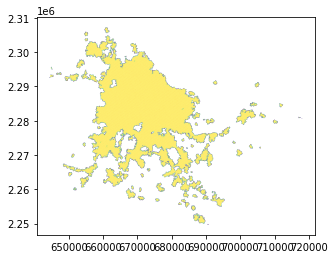

In [45]:
hex_urb[hex_urb.urb_pct>0].plot('urb_pct')

In [26]:
all_polys = gpd.GeoDataFrame()

for g in gdf_year.geometry.__geo_interface__['features'][0]['geometry']['coordinates']:
    dict_poly = {'type':'Polygon', 'coordinates':g}
    hexs = h3.polyfill(dict_poly, 12, geo_json_conformant = True)
    polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

    poly_tmp = gpd.GeoSeries(list(map(polygonise, hexs)), \
                                          index=hexs, \
                                          crs="EPSG:4326" \
                                         )
    gdf_tmp = gpd.GeoDataFrame(poly_tmp.reset_index()).rename(columns={'index':'hex_id_12',0:'geometry'})
    
    all_polys = all_polys.append(gdf_tmp, ignore_index=True)
    
    print((all_polys.to_crs("EPSG:32613").area.sum()/10000)/total_urban)

0    0.000092
dtype: float64
0    0.005982
dtype: float64
0    0.007224
dtype: float64
0    0.008097
dtype: float64
0    0.009302
dtype: float64
0    0.009731
dtype: float64
0    0.010493
dtype: float64
0    0.010495
dtype: float64
0    0.010647
dtype: float64
0    0.011427
dtype: float64
0    0.011472
dtype: float64
0    0.011472
dtype: float64
0    0.013124
dtype: float64
0    0.013124
dtype: float64
0    0.013125
dtype: float64
0    0.013129
dtype: float64
0    0.013853
dtype: float64
0    0.013858
dtype: float64
0    0.013862
dtype: float64
0    0.015346
dtype: float64
0    0.015346
dtype: float64
0    0.019834
dtype: float64
0    0.019886
dtype: float64
0    0.020388
dtype: float64
0    0.020389
dtype: float64
0    0.020389
dtype: float64
0    0.020909
dtype: float64
0    0.020967
dtype: float64
0    0.020968
dtype: float64
0    0.020968
dtype: float64
0    0.020968
dtype: float64
0    0.02097
dtype: float64
0    0.024203
dtype: float64
0    0.024203
dtype: float64
0    0.024203
d

KeyboardInterrupt: 

In [30]:
res = 12
hex_intersect = aup.create_hexgrid(gdf_year, res)

/home/edgar/Repos/Observatorio-ciudades/accesibilidad-urbana/aup/utils.py:335: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = polygon.explode().reset_index(drop=True)


In [31]:
print(hex_intersect.shape)
hex_intersect.head(2)

(2351802, 2)


,geometry,hex_id_12
0,"POLYGON ((-103.20237 20.34958, -103.20227 20.3...",8c49aa2a6b64bff
1,"POLYGON ((-103.20245 20.34941, -103.20235 20.3...",8c49aa2a44cb5ff


In [33]:
hexs = h3.polyfill(gdf_year.geometry.__geo_interface__['features'][0]['geometry'], 12, geo_json_conformant = True)

KeyError: 0

### Intersection

In [ ]:
res_union = hex_gdf.overlay(gdf_year, how='intersection')
res_union

### Percentage of urbanization

In [14]:
res_union['area'] = res_union.area/10000
print(res_union.shape)
res_union.head(2)

(1156, 5)


,hex_id_7,uso,geometry,year,area
0,87498c971ffffff,urbano,"POLYGON ((677290.003 2285796.523, 678822.104 2...",2015,610.98887
1,8749ab596ffffff,urbano,"POLYGON ((669186.861 2281106.879, 669842.524 2...",2015,611.06254


In [15]:
hex_area = np.mean(hex_gdf.area/10000)
res_union['urb_pct'] = round(res_union['area'] / hex_area, 5)
res_union.head(2)

,hex_id_7,uso,geometry,year,area,urb_pct
0,87498c971ffffff,urbano,"POLYGON ((677290.003 2285796.523, 678822.104 2...",2015,610.98887,0.99999
1,8749ab596ffffff,urbano,"POLYGON ((669186.861 2281106.879, 669842.524 2...",2015,611.06254,1.00011


### Merge with all hexagons

In [17]:
hex_mrg = hex_gdf.merge(res_union[['hex_id_7','urb_pct','year']], on='hex_id_7', how='left')
hex_mrg['urb_pct'].fillna(0, inplace=True)
print(hex_mrg.shape)
hex_mrg.head(4)

(1367, 4)


,geometry,hex_id_7,urb_pct,year
0,"POLYGON ((649466.557 2257379.960, 648810.594 2...",8749abc93ffffff,0.0,NaN
1,"POLYGON ((649025.275 2252099.238, 648369.367 2...",8749abc94ffffff,0.0,NaN
2,"POLYGON ((642244.161 2263253.432, 643120.788 2...",8749ab526ffffff,0.0,NaN
3,"POLYGON ((644648.271 2255094.427, 643771.702 2...",8749abc95ffffff,0.0,NaN


In [ ]:
hex_mrg.plot('urb_pct')

## Distance to urbanization

### Centroids from hexagons

In [17]:
G,_,_ = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [82]:
#hex_analysis = res_union.copy()
#hex_analysis['year'] = pd.to_numeric(hex_analysis['year'], downcast='integer')
#hex_analysis['distance_urb'] = np.nan
#hex_analysis['prev_year_urb'] = np.nan

In [18]:
year_prev = {2000:1990,
            2010:2005,
            2005:2000,
            2015:2010,
            2020:2015,
            1990:1980,
            1980:1970,
            1970:1940,
            1940:1902}

res_union['year'] = pd.to_numeric(res_union['year'], downcast='integer')

In [19]:
years = [1940,1970,1980,1990,2000,2005,2010,2015]

hex_urb_analysis = gpd.GeoDataFrame()

for y in years:
    #extract hexagons centroids for specific year
    hex_tmp = res_union.loc[res_union['year']==y].copy()
    hex_cnt = hex_tmp.centroid
    df_tmp = pd.DataFrame(hex_cnt, columns=['geometry'])
    hex_cnt = gpd.GeoDataFrame(df_tmp, geometry='geometry')
        
    #gather centroid from highly urbanized hexagons form a previous year
    hex_urb = res_union.loc[res_union['year']==year_prev[y]].copy()
    cnt_urb = hex_urb.loc[hex_urb.urb_pct>=0.8].centroid
    df_tmp = pd.DataFrame(cnt_urb, columns=['geometry'])
    cnt_urb = gpd.GeoDataFrame(df_tmp, geometry='geometry')
    
    #set crs and get coordinates
    hex_cnt = hex_cnt.set_crs("EPSG:32613")
    cnt_urb = cnt_urb.set_crs("EPSG:32613")
    hex_tmp = hex_tmp.to_crs("EPSG:32613")

    hex_cnt = hex_cnt.to_crs("EPSG:4326")
    cnt_urb = cnt_urb.to_crs("EPSG:4326")
    
    cnt_urb['x'] = cnt_urb.geometry.x
    cnt_urb['y'] = cnt_urb.geometry.y
    hex_cnt['x'] = hex_cnt.geometry.x
    hex_cnt['y'] = hex_cnt.geometry.y
    
    #calculate distance to previous year highly urbanized hexagos
    dist_node = aup.find_nearest(G, cnt_urb, hex_cnt, return_distance=True)
    dist_node = dist_node.to_crs("EPSG:32613")
    hex_dist_urb = hex_tmp.sjoin(dist_node[['geometry','distance_node']])[['geometry','hex_id_9','urb_pct','distance_node']].copy()
    hex_dist_urb.rename(columns={'distance_node':'distance_urb'}, inplace=True)
    
    hex_mrg = res_union.loc[res_union.year==y].merge(hex_dist_urb[['hex_id_9','distance_urb']], on='hex_id_9', how='left')
    hex_mrg['year'] = y
    
    hex_urb_analysis = hex_urb_analysis.append(hex_mrg)
        
    print(f"Finished year {y}")

Finished year 1940
Finished year 1970
Finished year 1980
Finished year 1990
Finished year 2000
Finished year 2005
Finished year 2010
Finished year 2015


In [20]:
hex_urb_analysis.head(4)

,geometry,hex_id_9,area,urb_pct,year,distance_urb
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,NaN,0.0,1940,3863.100157
1,"POLYGON ((671219.018 2280379.816, 671125.359 2...",89498c965c7ffff,NaN,0.0,1940,5151.182489
2,"POLYGON ((674262.460 2293058.515, 674481.366 2...",89498c94e73ffff,NaN,0.0,1940,4682.547826
3,"POLYGON ((672134.450 2291324.108, 672353.362 2...",89498c94c57ffff,NaN,0.0,1940,1979.995447


## Urbanization percentage previous year

In [21]:
hex_analysis = gpd.GeoDataFrame()

for y in years:
    
    hex_mrg = hex_urb_analysis.loc[hex_urb_analysis.year==y].merge(res_union.loc[
        res_union.year==year_prev[y]][['hex_id_9','urb_pct']], on='hex_id_9', how='left')
    
    hex_analysis = hex_analysis.append(hex_mrg)
    
    print(f"Finished year {y}")

Finished year 1940
Finished year 1970
Finished year 1980
Finished year 1990
Finished year 2000
Finished year 2005
Finished year 2010
Finished year 2015


In [22]:
hex_analysis.head(4)

,geometry,hex_id_9,area,urb_pct_x,year,distance_urb,urb_pct_y
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,NaN,0.0,1940,3863.100157,0.0
1,"POLYGON ((671219.018 2280379.816, 671125.359 2...",89498c965c7ffff,NaN,0.0,1940,5151.182489,0.0
2,"POLYGON ((674262.460 2293058.515, 674481.366 2...",89498c94e73ffff,NaN,0.0,1940,4682.547826,0.0
3,"POLYGON ((672134.450 2291324.108, 672353.362 2...",89498c94c57ffff,NaN,0.0,1940,1979.995447,0.0


In [23]:
hex_analysis = hex_analysis.rename(columns={'urb_pct_x':'urb_pct',
                                                              'urb_pct_y':'prev_year_urb'})

## Urbanization percentage next year

In [24]:
year_next = {1990:2000,
            2000:2005,
            2005:2010,
            2010:2015,
            1940:1970,
            1970:1980,
            1980:1990,
            2015:2020}

In [25]:
hex_tmp = gpd.GeoDataFrame()
years = [1940,1970,1980,1990,2000,2005,2010,2015]


for y in years:
    
    hex_mrg = hex_analysis.loc[hex_analysis.year==y].merge(res_union.loc[
        res_union.year==year_next[y]][['hex_id_9','urb_pct']], on='hex_id_9', how='left')
    
    hex_tmp = hex_tmp.append(hex_mrg)
    
    print(f"Finished year {y}")

hex_analysis = hex_tmp.copy()

Finished year 1940
Finished year 1970
Finished year 1980
Finished year 1990
Finished year 2000
Finished year 2005
Finished year 2010
Finished year 2015


In [26]:
hex_analysis.head(4)

,geometry,hex_id_9,area,urb_pct_x,year,distance_urb,prev_year_urb,urb_pct_y
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,NaN,0.0,1940,3863.100157,0.0,1.00003
1,"POLYGON ((671219.018 2280379.816, 671125.359 2...",89498c965c7ffff,NaN,0.0,1940,5151.182489,0.0,0.00000
2,"POLYGON ((674262.460 2293058.515, 674481.366 2...",89498c94e73ffff,NaN,0.0,1940,4682.547826,0.0,0.00000
3,"POLYGON ((672134.450 2291324.108, 672353.362 2...",89498c94c57ffff,NaN,0.0,1940,1979.995447,0.0,0.56561


In [27]:
hex_analysis = hex_analysis.rename(columns={'urb_pct_x':'urb_pct',
                                                              'urb_pct_y':'next_year_urb'})

### Download Graph from hippo

In [ ]:
hex_cnt = hex_mrg.centroid
df_tmp = pd.DataFrame(hex_cnt, columns=['geometry'])
hex_cnt = gpd.GeoDataFrame(df_tmp, geometry='geometry')
cnt_urb = hex_mrg.loc[hex_mrg.urb_pct>=0.9].centroid
df_tmp = pd.DataFrame(cnt_urb, columns=['geometry'])
cnt_urb = gpd.GeoDataFrame(df_tmp, geometry='geometry')

In [ ]:
hex_cnt = hex_cnt.to_crs("EPSG:4326")
cnt_urb = cnt_urb.to_crs("EPSG:4326")

In [ ]:
cnt_urb['x'] = cnt_urb.geometry.x
cnt_urb['y'] = cnt_urb.geometry.y
hex_cnt['x'] = hex_cnt.geometry.x
hex_cnt['y'] = hex_cnt.geometry.y

In [ ]:
dist_node = aup.find_nearest(G, cnt_urb, hex_cnt, return_distance=True)
dist_node = dist_node.to_crs("EPSG:32613")
hex_dist_urb = hex_mrg.sjoin(dist_node[['geometry','distance_node']])[['geometry','hex_id_7','urb_pct','distance_node']].copy()
hex_dist_urb.rename(columns={'distance_node':'distance_urb'}, inplace=True)

In [ ]:
hex_dist_urb.plot('distance_urb')

## Distance to urban Guadalajara center

In [28]:
hex_analysis = hex_analysis.set_crs("EPSG:32613")

In [29]:
gdf_cnt = gpd.read_file('../data/processed/Centralidades/Centralidades_AMG_2020-2040_UTM_v1.geojson', driver='GeoJSON')
gdf_cnt = gdf_cnt.to_crs("EPSG:4326")
print(gdf_cnt.shape)
gdf_cnt.head(1)

(27, 41)


,fid,nombre,clasif,can_rut_tp,cap_rut_tp,dens_pob,pers_ocupa,equipamien,l_tp_masiv,uni_econ,...,auxiliar17,auxiliar18,auxiliar19,auxiliar20,numero,n_centrali,RmvCnt,Tiempo,Cnt_Route,geometry
0,11.0,Centro Tlaquepaque,Centralidad Metropolitana,0.69,0.32,1.0,0.48,0.94,0.5,0.58,...,None,1.0,675392.648633,2.283998e+06,3.0,Centro &Tlaquepaque,2,2040,1,POINT (-103.31079 20.63935)


<AxesSubplot:>

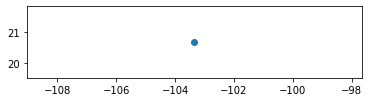

In [30]:
gdf_cnt = gdf_cnt[gdf_cnt['numero'].isin([2])]
gdf_cnt.plot()

In [31]:
gdf_cnt['x'] = gdf_cnt.geometry.x
gdf_cnt['y'] = gdf_cnt.geometry.y

In [32]:
dist_node = aup.find_nearest(G, gdf_cnt, hex_cnt, return_distance=True)
dist_node = dist_node.to_crs("EPSG:32613")
hex_analysis = hex_analysis.sjoin(dist_node[['geometry','distance_node']])[['geometry','hex_id_9','urb_pct','distance_urb',
                                                                            'distance_node','year','prev_year_urb','next_year_urb']].copy()
hex_analysis.rename(columns={'distance_node':'distance_centro'}, inplace=True)

In [33]:
print(hex_analysis.shape)
hex_analysis.head(4)

(218560, 8)


,geometry,hex_id_9,urb_pct,distance_urb,distance_centro,year,prev_year_urb,next_year_urb
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,0.00000,3863.100157,5266.45257,1940,0.00000,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,2662.331610,5266.45257,1970,0.00000,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1980,1.00003,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1990,1.00003,1.00003


<AxesSubplot:>

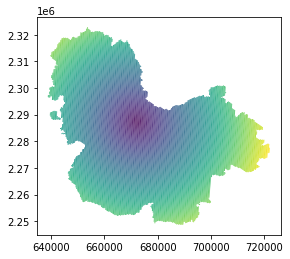

In [34]:
hex_analysis.loc[hex_analysis.year==2000].plot('distance_centro')

## Distance to centralities

In [35]:
gdf_cnt = gpd.read_file('../data/processed/Centralidades/Centralidades_AMG_2020-2040_UTM_v1.geojson', driver='GeoJSON')
gdf_cnt = gdf_cnt.to_crs("EPSG:4326")
print(gdf_cnt.shape)
gdf_cnt.head(1)

(27, 41)


,fid,nombre,clasif,can_rut_tp,cap_rut_tp,dens_pob,pers_ocupa,equipamien,l_tp_masiv,uni_econ,...,auxiliar17,auxiliar18,auxiliar19,auxiliar20,numero,n_centrali,RmvCnt,Tiempo,Cnt_Route,geometry
0,11.0,Centro Tlaquepaque,Centralidad Metropolitana,0.69,0.32,1.0,0.48,0.94,0.5,0.58,...,None,1.0,675392.648633,2.283998e+06,3.0,Centro &Tlaquepaque,2,2040,1,POINT (-103.31079 20.63935)


<AxesSubplot:>

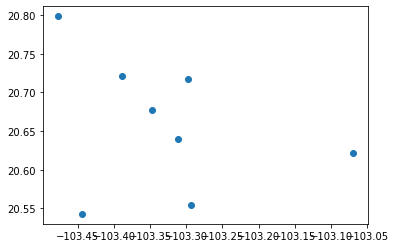

In [36]:
gdf_cnt = gdf_cnt[gdf_cnt['numero'].isin([1,2,3,6,21,23,24,25])]
gdf_cnt.plot()

In [37]:
gdf_cnt['x'] = gdf_cnt.geometry.x
gdf_cnt['y'] = gdf_cnt.geometry.y

In [38]:
dist_node = aup.find_nearest(G, gdf_cnt, hex_cnt, return_distance=True)
dist_node = dist_node.to_crs("EPSG:32613")
hex_analysis = hex_analysis.sjoin(dist_node[['geometry','distance_node']])[['geometry','hex_id_9','urb_pct','distance_urb',
                                                                            'distance_centro','year','prev_year_urb','distance_node','next_year_urb']].copy()
hex_analysis.rename(columns={'distance_node':'distance_centralities'}, inplace=True)

In [39]:
print(hex_analysis.shape)
hex_analysis.head(4)

(218560, 9)


,geometry,hex_id_9,urb_pct,distance_urb,distance_centro,year,prev_year_urb,distance_centralities,next_year_urb
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,0.00000,3863.100157,5266.45257,1940,0.00000,4645.733722,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,2662.331610,5266.45257,1970,0.00000,4645.733722,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1980,1.00003,4645.733722,1.00003
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1990,1.00003,4645.733722,1.00003


<AxesSubplot:>

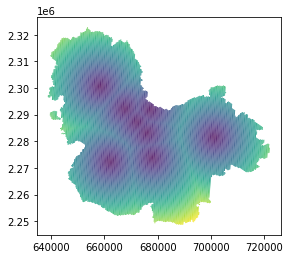

In [40]:
hex_analysis.loc[hex_analysis.year==1970].plot('distance_centralities')

## Year difference

In [42]:
hex_analysis['year_dif'] = hex_analysis['year'] - 1902

## Urbanization t+1

In [ ]:
gdf_year = gdf.loc[(gdf.year=='2015')].copy()
gdf_year = gdf_year.dissolve(by='year')
gdf_year.reset_index(drop=True, inplace=True)
gdf_year['uso'] = 'urbano'
gdf_year

In [ ]:
res_union = hex_gdf.overlay(gdf_year, how='intersection')
res_union

In [ ]:
res_union['area'] = res_union.area/10000
print(res_union.shape)
res_union.head(2)

In [ ]:
hex_area = np.mean(hex_gdf.area/10000)
res_union['urb_pct'] = round(res_union['area'] / hex_area, 5)
res_union.head(2)

In [ ]:
hex_mrg = hex_gdf.merge(res_union[['hex_id_7','urb_pct']], on='hex_id_7', how='left')
hex_mrg['urb_pct'].fillna(0, inplace=True)
print(hex_mrg.shape)
hex_mrg.head(4)

In [ ]:
hex_mrg.rename(columns={'urb_pct':'urb_pct_15'}, inplace=True)
hex_for_pred = hex_dist_urb.merge(hex_mrg[['hex_id_7','urb_pct_15']], on='hex_id_7')
hex_for_pred['time_dif'] = 5
print(hex_for_pred.shape)
hex_for_pred.head(2)

## Model

In [77]:
hex_for_pred = hex_analysis.dropna().copy()
print(hex_for_pred.shape)
hex_for_pred.head(4)

(218560, 10)


,geometry,hex_id_9,urb_pct,distance_urb,distance_centro,year,prev_year_urb,distance_centralities,next_year_urb,year_dif
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,0.00000,3863.100157,5266.45257,1940,0.00000,4645.733722,1.00003,38
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,2662.331610,5266.45257,1970,0.00000,4645.733722,1.00003,68
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1980,1.00003,4645.733722,1.00003,78
0,"POLYGON ((671345.303 2281889.224, 671564.195 2...",89498c9656bffff,1.00003,0.000000,5266.45257,1990,1.00003,4645.733722,1.00003,88


In [78]:
hex_for_pred['urb'] = np.nan
hex_for_pred['urb'].loc[hex_for_pred.urb_pct>=0.7] = 1
hex_for_pred['urb'].loc[hex_for_pred.urb_pct<0.7] = 0

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

scaler = MinMaxScaler()

X = hex_for_pred[['prev_year_urb','distance_urb','distance_centro',
                  'year_dif','distance_centralities','year','next_year_urb']].to_numpy()
Y = hex_for_pred[['urb_pct']].to_numpy()

X_train, X_test, y_train, y_test = (
train_test_split(X,
                Y,
                random_state=0))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear regression

In [98]:
hex_for_pred.year.unique()

array([1940, 1970, 1980, 1990, 2000, 2005, 2010, 2015])

In [160]:
clf = LinearRegression().fit(X_train_scaled, y_train)


In [161]:
clf.score(X_train_scaled, y_train)

0.8988180420729107

In [162]:
clf.score(X_test_scaled, y_test)

0.8940889208717642

### Result analysis for 2015

In [188]:
hex_15 = hex_for_pred.loc[hex_for_pred.year==1970].copy()
X_15 = hex_15[['prev_year_urb','distance_urb','distance_centro',
                  'year_dif','distance_centralities','year','next_year_urb']].to_numpy()
X_15_scaled = scaler.fit_transform(X_15)

In [189]:
hex_15['predicted_15'] = clf.predict(X_15_scaled)

<AxesSubplot:>

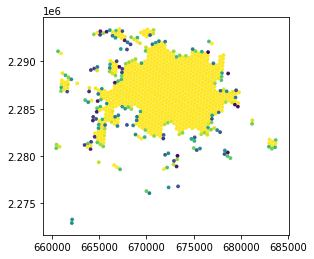

In [190]:
hex_15.loc[hex_15.urb_pct>=0.7].plot('urb_pct')

<AxesSubplot:>

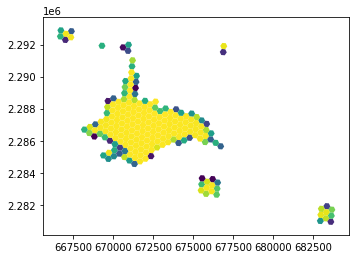

In [193]:
hex_15.loc[hex_15.predicted_15>=0.7].plot('predicted_15')

In [194]:
hex_15.loc[hex_15.urb>=0.7].area.sum()/10000

11524.41332434724

In [195]:
hex_15.loc[hex_15.predicted_15>=0.7].area.sum()/10000

2681.4913244554564

## Neural network

In [80]:
X.shape

(218560, 7)

In [81]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
import tensorflow as tf

In [82]:
def neuron_layers(nx, nh, ny, hl, act, r, seed=None):
    
    tf.keras.regularizers.l1(l1=r)
    
    initializer = tf.keras.initializers.RandomNormal(seed=seed)
    
    model = Sequential()
    
    for i in range(1, 3+hl):
        
        if i == 1:
            model.add(Dense(nx, input_dim=7, kernel_initializer=initializer,
                            activation=act,kernel_regularizer='l1'))
            
        elif i == (2+hl):
            model.add(Dense(ny, activation='linear'))
            
        else:
            model.add(Dense(nh, activation=act))
            
    return model

In [108]:
nh = 10
hl = 5
r = 0.01
a = 'relu'
e = 200

model = neuron_layers(8, nh, 1, hl, a, r)

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model.fit(X_train_scaled, y_train, epochs=e, batch_size=50,  verbose=0, validation_split=0.2)

In [109]:
y_hat= model.predict(X_train_scaled)
acc_train = round(r2_score(y_train, y_hat),3)
mse_train = round(mean_squared_error(y_train, y_hat),3)
mae_train = round(mean_absolute_error(y_train, y_hat),3)

y_hat = model.predict(X_test_scaled)
acc_test = round(r2_score(y_test, y_hat),3)
mse_test = round(mean_squared_error(y_test, y_hat),3)
mae_test = round(mean_absolute_error(y_test, y_hat),3)

print('Train:',str(acc_train),str(mse_train),str(mae_train),'\n',
     'Test:',str(acc_test),str(mse_test),str(mae_test))

Train: 0.908 0.009 0.024 
 Test: 0.905 0.009 0.024


In [220]:
hex_15 = hex_for_pred.loc[hex_for_pred.year==2015].copy()
X_15 = hex_15[['prev_year_urb','distance_urb','distance_centro',
                  'year_dif','distance_centralities','year','next_year_urb']].to_numpy()
X_15_scaled = scaler.fit_transform(X_15)

In [221]:
hex_15['predicted_15'] = model.predict(X_15_scaled)

<AxesSubplot:>

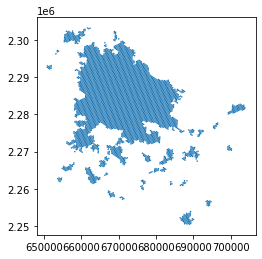

In [222]:
hex_15.loc[hex_15.urb_pct>=0.7].plot()

<AxesSubplot:>

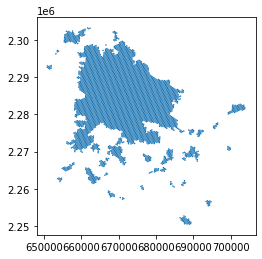

In [223]:
hex_15.loc[hex_15.predicted_15>=0.2].plot()

In [224]:
hex_15.loc[hex_15.urb_pct>=0.7].area.sum()/10000

62952.18163327111

In [225]:
hex_15.loc[hex_15.predicted_15>=0.2].area.sum()/10000

62840.66986813236

In [196]:
hex_15 = hex_for_pred.loc[(hex_for_pred.year==1980)&(hex_for_pred.prev_year_urb<0.8)].copy()
X_15 = hex_15[['prev_year_urb','distance_urb','distance_centro',
                  'year_dif','distance_centralities','year','next_year_urb']].to_numpy()
X_15_scaled = scaler.fit_transform(X_15)

In [197]:
hex_15['predicted_15'] = model.predict(X_15_scaled)

In [198]:
y_hat_15 = hex_15['predicted_15'].to_numpy()
y_test_15 = hex_15['urb_pct'].to_numpy()

In [199]:
acc_train = round(r2_score(y_test_15, y_hat_15),3)
mse_train = round(mean_squared_error(y_test_15, y_hat_15),3)
mae_train = round(mean_absolute_error(y_test_15, y_hat_15),3)
print('Train:',str(acc_train),str(mse_train),str(mae_train))

Train: 0.428 0.013 0.029


<AxesSubplot:>

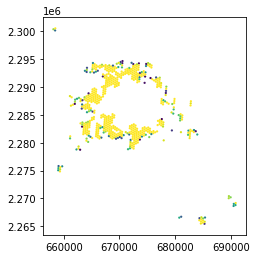

In [200]:
hex_15.loc[hex_15.urb_pct>=0.7].plot('urb_pct')

<AxesSubplot:>

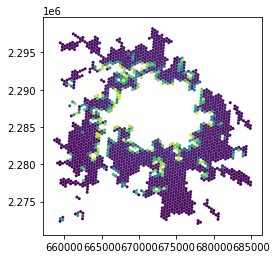

In [201]:
hex_15.loc[hex_15.predicted_15>=0.2].plot('predicted_15')